In [ ]:
!git clone https://github.com/ishanchadha01/eeg-ml.git

Cloning into 'eeg-ml'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 270 (delta 45), reused 91 (delta 29), pack-reused 161
Receiving objects: 100% (270/270), 478.54 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Checking out files: 100% (97/97), done.


In [ ]:
!python3 -m pip install mne

     |████████████████████████████████| 6.6MB 2.6MB/s 


In [ ]:
cd eeg-ml/project/data/

/content/eeg-ml/project/data


In [ ]:
!python make_csv.py

Extracting EDF parameters from /content/eeg-ml/project/data/raw-data/00010189/s001_2013_01_16/00010189_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eeg-ml/project/data/raw-data/00010198/s001_2013_01_16/00010198_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eeg-ml/project/data/raw-data/00010196/s001_2013_01_14/00010196_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eeg-ml/project/data/raw-data/00010170/s001_2013_01_18/00010170_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/eeg-ml/project/data/raw-data/00010126/s001_2013_02_20/00010126_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.inf

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
import os

In [ ]:
#To save checkpoints
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
class GAN():

  def __init__(self):
    self.rows = 24
    #Probalby will change in the future
    self.cols = 3
    self.output = 3
    
    self.generator = self.generator_model()
    self.discriminator = self.discriminator_model()


    #Also need to change later
    self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    self.checkpoint_dir = '/content/gdrive/My Drive/model/'

    #TODO: Change the loss to something else
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


  def load_weights(self, epoch):
    self.generator.load_weights(self.checkpoint_dir+f"generator{epoch}")
    self.discriminator.load_weights(self.checkpoint_dir+f"discriminator{epoch}")
    print("Weights loaded")
  
  def generator_model(self):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(self.rows, self.cols)))
    model.add(layers.Bidirectional(layers.LSTM(256)))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))
    
    # model.add(layers.Dense(512))
    # model.add(layers.LeakyReLU(alpha=0.3))
    # model.add(layers.Dropout(0.3))

    # model.add(layers.Dense(512))
    # model.add(layers.LeakyReLU(alpha=0.3))
    # model.add(layers.Dropout(0.3))

    model.add(layers.Dense(self.rows*self.output))
    model.add(tf.keras.layers.Reshape((self.rows,self.output)))

    return model
  
  def discriminator_model(self):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(self.rows,self.output)))
    model.add(layers.Bidirectional(layers.LSTM(256)))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.3))
    model.add(layers.Dropout(0.3))
    # model.add(layers.Dense(512))
    # model.add(layers.LeakyReLU(alpha=0.3))
    # model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

  def discriminator_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

  def generator_loss(self,fake_output):
    #TODO: Change to the usefull loss from the paper
    return self.cross_entropy(tf.ones_like(fake_output), fake_output)

  def train(self, eeg_data, epochs):
    
    start = time.time()
    for epoch in range(epochs):
      

      if (epoch) % 10 == 0:
        self.generator.save_weights(self.checkpoint_dir+f"generator{epoch}")
        self.discriminator.save_weights(self.checkpoint_dir+f"discriminator{epoch}")
        print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))
        start = time.time()

      for eeg_batch, real_eeg in eeg_data:
        #Eeg_batch.shape = (baches,24,self.cols), real_eeg.shape = (baches,24,self.output)
        self.train_step(eeg_batch, real_eeg)
      



  @tf.function
  def train_step(self, eeg_batch, real_eeg_data):
    #Slighlty modified code from Tensorflow GAN tutorial
    #I don't think this does what it should do

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_eeg = self.generator(eeg_batch, training=True)

        real_eeg = self.discriminator(real_eeg_data, training=True)
        fake_eeg = self.discriminator(generated_eeg, training=True)
        

        gen_loss = self.generator_loss(fake_eeg)
        disc_loss = self.discriminator_loss(real_eeg, fake_eeg)

    gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    

    self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))


  def make_batches(self, data, batches):
    data_eeg = []
    for i in range(0, data.shape[1] - batches*self.cols, batches*self.cols):
      data_points = data[:,i:i+batches*self.cols].reshape(batches, self.rows,self.cols)
      output = np.stack([data[:,i+k*self.cols+1:i+k*self.cols+4] for k in range(batches)])
      data_eeg.append([data_points,output])
    return data_eeg
    
    
  def rmsd(self, data):
    values = []
    data_eeg = []
    outputs = []
    for i in range(0, data.shape[1] - 10000*self.cols, 10000*self.cols):
      data_points = data[:,i:i+10000*self.cols].reshape(10000, self.rows,self.cols)
      output = np.stack([data[:,i+k*self.cols+1:i+k*self.cols+4] for k in range(10000)])
      outputs.append(output)
      data_eeg.append([data_points,output])

    total = 0

    for data, output in data_eeg:
      generated_data = self.generator(data, training=False)
      values.append(np.sum((generated_data - output)**2,axis=0))
      total += generated_data.shape[0]

    outputs = np.stack(outputs).reshape(total, self.rows, self.cols)
    print(outputs.shape)
    
    return sum(values)**0.5/total/(np.max(outputs) - np.min(outputs))
  
  def mape(self, data):
    values = []
    data_eeg = []
    for i in range(0, data.shape[1] - 10000*self.cols, 10000*self.cols):
      data_points = data[:,i:i+10000*self.cols].reshape(10000, self.rows,self.cols)
      output = np.stack([data[:,i+k*self.cols+1:i+k*self.cols+4] for k in range(10000)])
      data_eeg.append([data_points,output])
    
    total = 0
    for data, output in data_eeg:
      generated_data = self.generator(data, training=False)
      values.append(np.sum(np.abs((output-generated_data)/output),axis=0))
      total += generated_data.shape[0]

    return sum(values)/total

In [ ]:
cd csv-data/

/content/eeg-ml/project/data/csv-data


In [ ]:
!ls

00010100_s001_t000.csv	00010159_s001_t000.csv	00010182_s001_t000.csv
00010102_s001_t000.csv	00010164_s001_t000.csv	00010183_s001_t000.csv
00010108_s001_t000.csv	00010164_s002_t000.csv	00010184_s001_t000.csv
00010109_s001_t000.csv	00010165_s001_t000.csv	00010186_s001_t000.csv
00010112_s001_t000.csv	00010167_s001_t000.csv	00010188_s001_t000.csv
00010120_s001_t000.csv	00010170_s001_t000.csv	00010189_s001_t000.csv
00010122_s001_t000.csv	00010171_s001_t000.csv	00010190_s001_t000.csv
00010124_s001_t000.csv	00010172_s001_t000.csv	00010194_s001_t001.csv
00010126_s001_t000.csv	00010174_s001_t000.csv	00010195_s001_t000.csv
00010141_s001_t000.csv	00010175_s001_t001.csv	00010196_s001_t001.csv
00010147_s001_t000.csv	00010178_s001_t000.csv	00010198_s001_t000.csv
00010149_s001_t000.csv	00010179_s001_t000.csv	00010199_s001_t001.csv


In [ ]:
#Load all data
import numpy as np

#data =  np.loadtxt(open(f"00010100_s001_t000.csv", "rb"), delimiter=",", skiprows=1).T[:24,:]
data = None
for i in range(120,122):#200):
 
  try:
    if data == None:
      data = np.loadtxt(open(f"00010{i}_s001_t000.csv", "rb"), delimiter=",", skiprows=1).T[:24,:]
    else:
      data = np.concatenate((data, np.loadtxt(open(f"00010{i}_s001_t000.csv", "rb"), delimiter=",", skiprows=1).T[:24,:]), axis=1)
    print(data.shape)
  except Exception as e:
    pass
print(data.shape)


# other_files = ["00010164_s002_t000.csv","00010175_s001_t001.csv","00010194_s001_t001.csv","00010196_s001_t001.csv","00010199_s001_t001.csv"]
# for name in other_files:
#   data = np.concatenate((data, np.loadtxt(open(f"{name}", "rb"), delimiter=",", skiprows=1).T[:24,:]),axis=1)
# print(data.shape)

#Split data to the batches
data = data*100
data_eeg = gan.make_batches(data, 2500)
print(len(data_eeg))

(24, 375500)
(24, 375500)


In [ ]:
gan = GAN() 
#After 250 epochs
gan.load_weights(50)

Weights loaded


In [ ]:
mape = gan.mape(data)
print(np.sum(mape, axis=0)/24)



[141681.98262222 138486.80452222 150513.88294722]


In [ ]:
#Probably wrong now

rmsd = gan.rmsd(data)
#print(rmsd)
print(np.sum(rmsd,axis=0)/24)

(120000, 24, 3)
[0.20642696 0.20704998 0.22187314]


In [ ]:
#gan.train(data_eeg,epochs=500)

Time for epoch 0 is 0.7149438858032227 sec
Time for epoch 10 is 500.47333312034607 sec
Time for epoch 20 is 487.3558850288391 sec
Time for epoch 30 is 487.2718617916107 sec
Time for epoch 40 is 486.6597592830658 sec


(24, 379000)


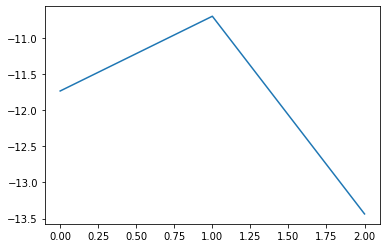

In [ ]:
import matplotlib.pyplot as plt

data_csv =  np.loadtxt(open(f"00010102_s001_t000.csv", "rb"), delimiter=",", skiprows=1).T[:24,:]
print(data_csv.shape)
data_csv = data_csv*100


generated_data = gan.generator(data_csv[:24,0:3].reshape(1,24,3), training=False)
real_data = data_csv[:24,201:206]

plt.plot([i for i in range(3)], generated_data[0,0,:])

# for i in range(24):
#   plt.figure()
#   plt.plot([i for i in range(500)], data_csv[i,:500])


In [ ]:
generated_data = gan.generator(data_csv[:24,:3].reshape(1,24,3), training=False)
for i in range(1,20):
  generated = gan.generator(data_csv[:24,0+i*3:3+3*i].reshape(1,24,3), training=False)
  generated_data = tf.concat((generated_data, generated), axis=2)
  



(1, 24, 60)
(1, 60)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

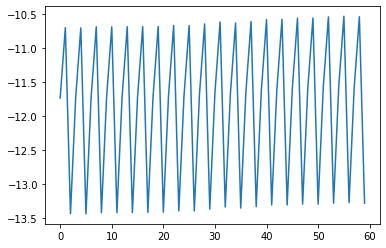

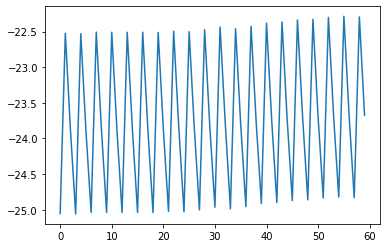

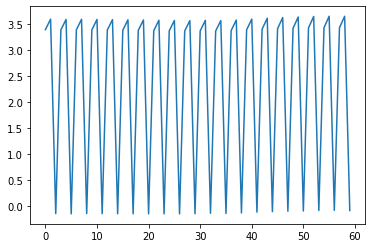

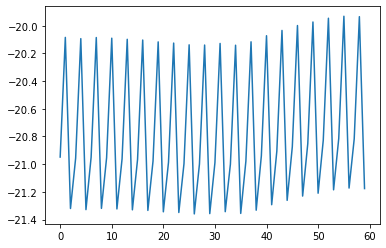

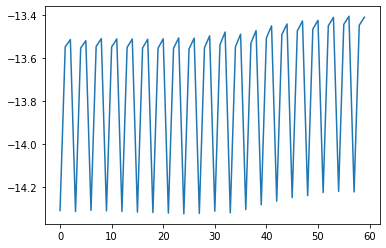

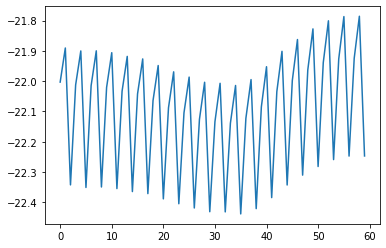

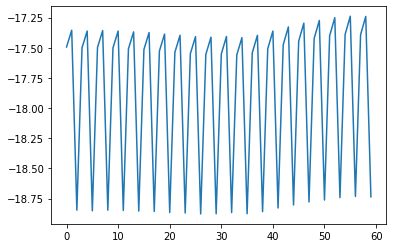

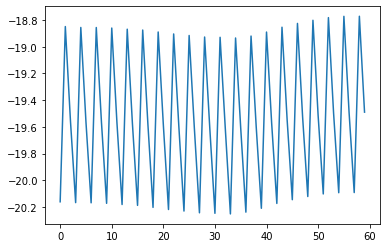

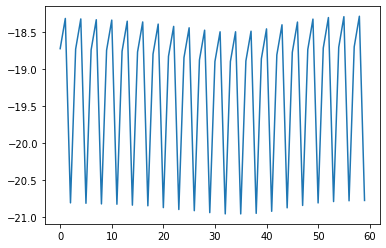

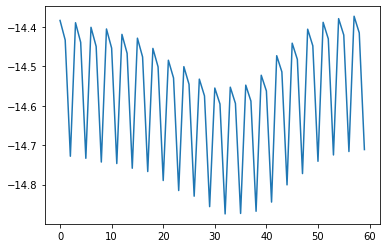

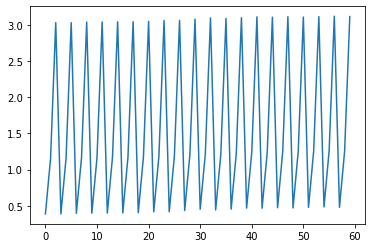

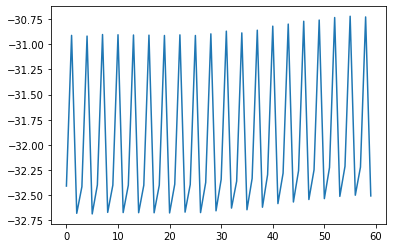

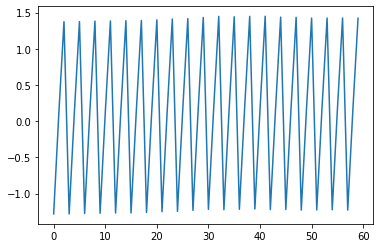

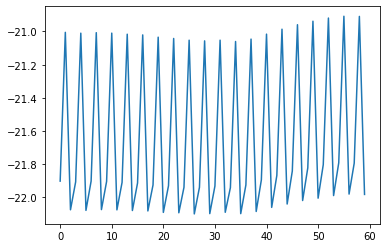

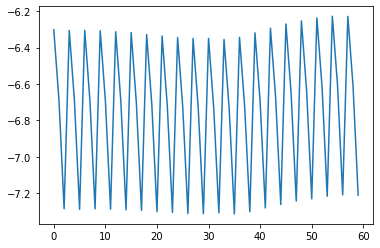

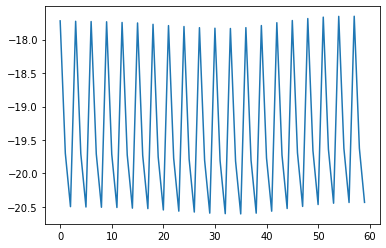

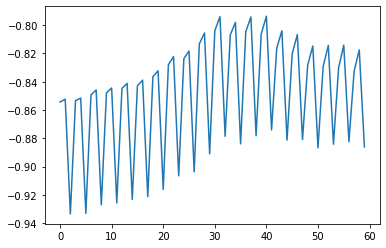

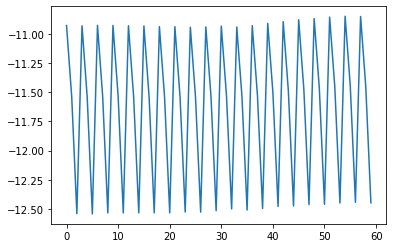

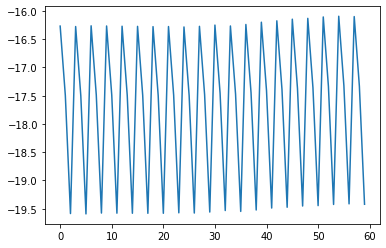

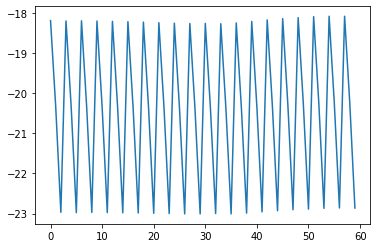

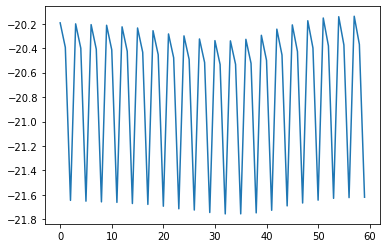

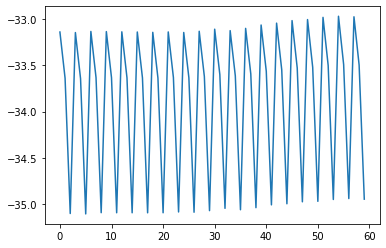

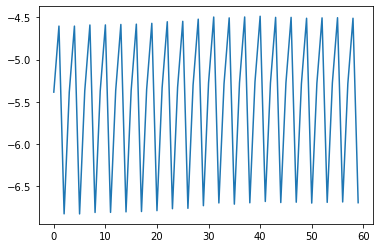

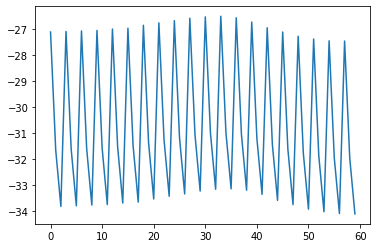

In [ ]:
print(generated_data.shape)
print(generated_data[:,0,:].shape)
for i in range(24):
  plt.figure()
  plt.plot([i for i in range(3*20)], generated_data[0,i,:])
